(parameters_recovery)=
# Parameters recovery, prior predictive and posterior predictive sampling

In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
    ! pip install pyhgf

In [2]:
from numpy import loadtxt
import numpy as np
from pyhgf.distribution import hgf_logp, HGFDistribution
from pyhgf import load_data
import jax.numpy as jnp
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

np.random.seed(123)

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In this tutorial, we are going to demonstrate some forms of parameters recovery, prior predictive and posterior predictive sampling that can be a way to assess the strength of the model fitting.

## Continuous HGF
### Simulate a dataset

In [3]:
n_data = 6
dataset = []
for participant in range(n_data):
    input_data = []
    kappa_1 = 1.0
    omega_1 = -10.0
    omega_2 = -10.0
    mu_1 = 0.0
    mu_2 = 0.0
    pi_1 = 1e4
    pi_2 = 1e1
    
    # two-level hierarchical gaussian random walk
    for i in range(1000):
        
        # x2
        pi_2 = np.exp(omega_2)
        mu_2 = np.random.normal(mu_2, pi_2**.5)

        # x1
        pi_1 = np.exp(kappa_1 * mu_2 + omega_1)
        mu_1 = np.random.normal(mu_1, pi_1**.5)
        
        # input node
        u = np.random.normal(mu_1, 1e-4**.5)
        input_data.append(u)

    dataset.append(np.array(input_data))

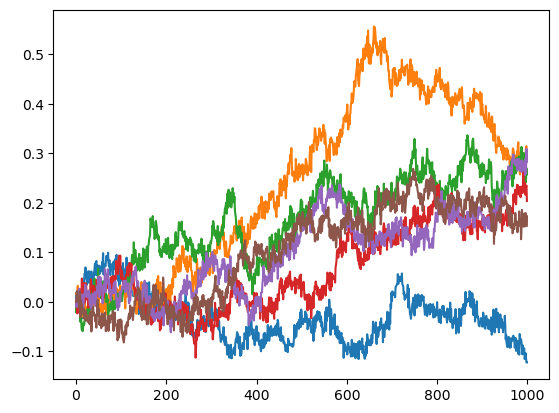

In [4]:
for rw in dataset:
    plt.plot(rw)

## Embedding a serie of HGFs in a graphical model

Here, we are goingin to estimate the parameter $omega_{1}$ from the time series created by the hierarchical random walks. All the time series were generated using $omega_{1} = -10.0$ and we want to see how the Bayesian inference can retrieve these values.

In [5]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="continuous",
    input_data=dataset,
)

In [6]:
with pm.Model() as model:
    
    # Priors
    #-------
    omega_1 = pm.Normal("omega_1", mu=0.0, sigma=2.0, shape=n_data)

    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            omega_1=omega_1,
            omega_2=-10.0,
            omega_input=np.log(1e-4),
            rho_1=0.0,
            rho_2=0.0,
            pi_1=1e4,
            pi_2=1e1,
            mu_1=0.0,
            mu_2=0.0,
            kappa_1=1.0,
            omega_3=jnp.nan,
            rho_3=jnp.nan,
            pi_3=jnp.nan,
            mu_3=jnp.nan,
            kappa_2=jnp.nan
        ),
    )

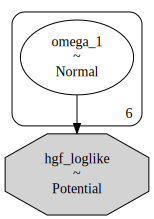

In [7]:
pm.model_to_graphviz(model)

In [8]:
with model:
    idata = pm.sample(chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Sequential sampling (1 chains in 1 job)
NUTS: [omega_1]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


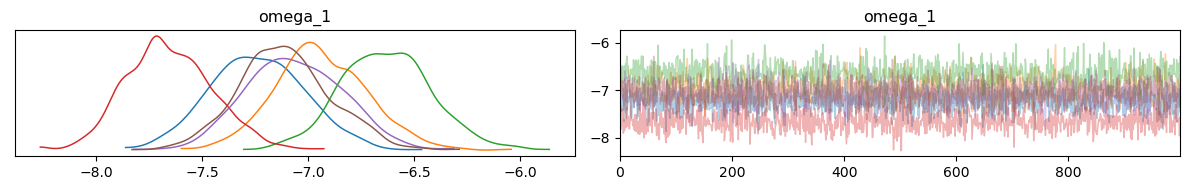

In [9]:
az.plot_trace(idata);
plt.tight_layout()

In [10]:
az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega_1[0],-7.239,0.222,-7.682,-6.849,0.005,0.004,1659.0,744.0,NaN
omega_1[1],-6.939,0.221,-7.335,-6.514,0.007,0.005,1171.0,740.0,NaN
omega_1[2],-6.632,0.216,-7.025,-6.212,0.006,0.004,1179.0,635.0,NaN
omega_1[3],-7.653,0.205,-7.997,-7.251,0.006,0.004,1190.0,649.0,NaN
omega_1[4],-7.064,0.228,-7.456,-6.635,0.006,0.004,1716.0,748.0,NaN
omega_1[5],-7.110,0.221,-7.499,-6.681,0.006,0.004,1563.0,688.0,NaN
